In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.utils.vis_utils import plot_model

import data_preprocessing as dp
import utilities
import models.training as train
import models.autoencoder
from models.autoencoder import ConvolutionalAutoencoder
from models.classifiers import EEGNet

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
title = 'subject_one_no_augmentation_bs3'

In [20]:
sklearn.utils.shuffle?

Signature: sklearn.utils.shuffle(*arrays, random_state=None, n_samples=None)
Docstring:
Shuffle arrays or sparse matrices in a consistent way.

This is a convenience alias to ``resample(*arrays, replace=False)`` to do
random permutations of the collections.

Parameters
----------
*arrays : sequence of indexable data-structures
    Indexable data-structures can be arrays, lists, dataframes or scipy
    sparse matrices with consistent first dimension.

random_state : int, RandomState instance or None, default=None
    Determines random number generation for shuffling
    the data.
    Pass an int for reproducible results across multiple function calls.
    See :term:`Glossary <random_state>`.

n_samples : int, default=None
    Number of samples to generate. If left to None this is
    automatically set to the first dimension of the arrays.  It should
    not be larger than the length of arrays.

Returns
-------
shuffled_arrays : sequence of indexable data-structures
    Sequence of shuff

### Create Dataset with EEG-Data compressed by trained Autoencoder

```python
data, events = dp.load_data()
data, events = dp.choose_condition(data, events, 'inner speech')
norm_data = data.astype(np.float16) * 100_000  # NORMALIZATION ONLY POSSIBLE BY MULTIPLYING HERE?
norm_data = dp.normalization(norm_data)

dataset = tf.data.Dataset.from_tensor_slices((norm_data, events[:, 1]))
dataset = dp.preprocessing_pipeline(
    dataset,
    functions = [dp.filter_interval_tensor,
                 lambda sample:(sample[0], tf.one_hot(sample[1], 4)), # one-hot
                 lambda sample: (tf.reshape(sample[0], (128, 640, 1)),
                                 sample[1])],
    args = [[[1, 3.5], 256], [], []],
    batch_size = 12
)

# save dataset so that we can just load the preprocessed version next time
tf.data.experimental.save(dataset, 'dataset/preprocessed/auto_class_ds')
```

In [3]:
# load datasets
datasets = {key:tf.data.experimental.load(f'dataset/preprocessed/{title}/{key}') for key in ('train', 'test', 'valid')}

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-17 21:48:37.204060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-17 21:48:37.204238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
autoencoder_datasets = {key:ds.map(lambda input, clean_input, target: (input, target)) for key, ds in datasets.items()}

In [5]:
# load dataset created previously
##dataset = tf.data.experimental.load('dataset/preprocessed/auto_class_ds')
# Load autoencoder-model
autoencoder_trained = tf.keras.models.load_model(f'./models/saved_models/{title}')
# create dataset by extracting latent space for every sample
autoencoded_datasets = {key:models.autoencoder.latent_dataset(autoencoder_trained.encoder, ds) for key, ds in autoencoder_datasets.items()}
##autoencoded_dataset = autoencoded_dataset.shuffle(200)
##autoencoded_datasets = dp.split_dataset(autoencoded_dataset)

In [6]:
%matplotlib tk
for i, t in autoencoded_datasets['valid'].take(1):
    print(t[0])
    # normalize
    norm_enc = i[0] / np.max(i[0], (0, 1))[np.newaxis, np.newaxis, :]
    plt.imshow(norm_enc)
    print(norm_enc.shape)
    plt.show()

tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)


2022-03-17 16:26:11.538595: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-17 16:26:11.544902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(32, 40, 3)


### Classify Autoencoded Dataset

In [7]:
#from models.classifiers import ConvAuto1

#model1 = ConvAuto1()
#model1.build((12, 32, 40, 3))
#model1.summary()

In [18]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Normalization, LeakyReLU, Activation, BatchNormalization, MaxPool2D

class ConvAuto2(Model):
    def __init__(self):
        """
        init: constructor of model
        call: performs forward pass of model
        """
        super(ConvAuto2, self).__init__()

        """
            Conv2D(filters=4, kernel_size=(3,3)),
            #BatchNormalization(),
            LeakyReLU(),
            Dropout(0.6),
            Conv2D(filters=3, kernel_size=(3,3)),
            #BatchNormalization(),
            LeakyReLU(),
            Dropout(0.3),
            Conv2D(filters=2, kernel_size=(3,3)),
            #BatchNormalization(),
            LeakyReLU(),
            tf.keras.layers.GlobalAveragePooling2D(),
        """
        self.layer_list = [
            Conv2D(filters=16, kernel_size=(3,3), strides=2),
            Conv2D(filters=8, kernel_size=(3,3), strides=2),
            tf.keras.layers.GlobalAveragePooling2D(),
            Dense(10),
            Dense(4, activation='softmax')
        ]

    @tf.function
    def call(self, inputs, training=None) -> tf.Tensor:
        """ Computes a forward step with the given data
        Parameters
        ----------
        inputs : tf.Tensor
            the input for the model
        training : bool
            true if call has been made from train_step, which tells the dropout layer to be active 
        Returns
        ----------
        x : tf.Tensor
            the output of the model
        """
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        return x

model1 = EEGNet(4,kernLength=32, dropoutRate=0.8, dropoutType='Dropout')
#model1.build((None, 32, 40, 3))
model1.summary()

model_name = '32_32_8_20Epochs'
#plot_model(model1, to_file=f'./models/saved_models/classifiers/{model_name}_info.png', show_shapes=True, show_layer_names=True, expand_nested=True)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 640, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 640, 8)       256       
                                                                 
 batch_normalization_15 (Bat  (None, 128, 640, 8)      32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_5 (Depthwi  (None, 1, 640, 16)       2048      
 seConv2D)                                                       
                                                                 
 batch_normalization_16 (Bat  (None, 1, 640, 16)       64        
 chNormalization)                                                
                                                           

In [11]:
for i, t in autoencoded_datasets['train'].take(1):
    print(tf.shape(t))

NameError: name 'autoencoded_datasets' is not defined

In [19]:
%matplotlib tk

# Initialize the loss-function
loss_func = tf.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()
# Initialize Train-Object
trainer = train.Trainer(model1, autoencoder_datasets,
                        optimizer, loss_func, train.accuracy)
# Initialize Plotting-Object
grapher = utilities.TrainingGrapher(3,1, supxlabel='Epochs', axs_xlabels=[['Train Loss', 'Test Loss', 'Test Accuracy']])

trainer.model_test()
for epoch in range(100):
    print("Epoch:", epoch, trainer.losses['train'], end='\r')
    trainer.train_epoch()
    grapher.update([trainer.losses['train'], trainer.losses['test'], trainer.accuracies['test']])

print(trainer.test('valid'))


(<tf.Tensor: shape=(), dtype=float32, numpy=13.118388>, <tf.Tensor: shape=(), dtype=float64, numpy=0.16666666666666666>)1738, 1.0088427066802979, 0.7970809936523438, 0.5867419242858887, 0.3911995589733124, 0.2128131091594696, 0.09165009111166, 0.04923265054821968, 0.03604869544506073, 0.0310842152684927, 0.04118018597364426, 0.10178423672914505, 0.38197651505470276, 0.4810134172439575, 0.3824930191040039, 0.08165858685970306, 0.032004762440919876, 0.01614665426313877, 0.007291373796761036, 0.00604674406349659, 0.0052329907193779945, 0.004605018068104982, 0.004100313410162926, 0.003683878807350993, 0.003333563916385174, 0.0030344596598297358, 0.0027760551311075687, 0.0025506047531962395, 0.0023522661067545414, 0.0021765525452792645, 0.0020199145656079054, 0.0018795268842950463, 0.0017530868062749505, 0.0016387058421969414, 0.0015348495217040181, 0.0014401994412764907, 0.0013536777114495635, 0.001274343580007553, 0.0012013959931209683, 0.0011341666104272008, 0.0010720215504989028, 0.0010

In [13]:

print(trainer.test('valid'))

(<tf.Tensor: shape=(), dtype=float32, numpy=12.139858>, <tf.Tensor: shape=(), dtype=float64, numpy=0.2333333333333333>)


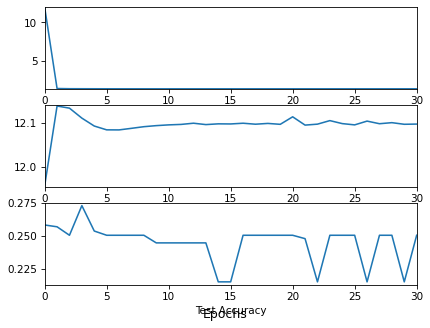

In [ ]:
%matplotlib inline
#rapher.fig.set_size_inches(18.5, 10.5)
grapher.fig

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model1.save(f'./models/saved_models/classifiers/{model_name}')
grapher.fig.savefig(f'./models/saved_models/classifiers/{model_name}_info')

INFO:tensorflow:Assets written to: ./models/saved_models/classifiers/32_32_8_20Epochs/assets


2022-03-17 16:09:47.235388: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
